# Intro

Now that the data has been transformed into a usual, some elementary EDA will be performed to check the numerical features.

In [12]:
import pandas as pd
from os.path import join
from os import listdir

In [13]:
def read_batches(path):
    """
    Read the batches stored in the path and group them
    :param path: the path with batches
    :return: a pandas dataframe with the grouped and de-duplicated batches
    """
    # Regroup batches
    batches = [pd.read_csv(join(path, f)) for f in listdir(path)]

    # After creating the random observations, potential duplicates (although unlikely) need to be dropped
    observations = pd.concat(batches)
    observations.drop_duplicates(subset=["date", "asset_file"])

    observations.date = pd.to_datetime(observations.date)

    observations.dropna(inplace=True)

    return observations

In [14]:
observations = read_batches("DataBatches")

In [15]:
observations

,asset_file,date,stock,1_month_return,6_month_return,12_month_return,1_month_volatility,6_month_volatility,12_month_volatility,1_month_img,6_month_img,12_month_img,label
0,Data/Stocks\coty.us.txt,2016-01-22,1,-0.151798,-0.150866,0.185205,0.019828,0.023280,0.024463,Charts/img_500_1_month.PNG,Charts/img_500_6_month.PNG,Charts/img_500_12_month.PNG,2
1,Data/Stocks\etw.us.txt,2008-12-01,1,-0.124379,-0.462061,-0.476264,0.039048,0.031644,0.024240,Charts/img_501_1_month.PNG,Charts/img_501_6_month.PNG,Charts/img_501_12_month.PNG,2
2,Data/Stocks\bsft.us.txt,2011-09-01,1,0.073076,-0.194836,2.734568,0.074986,0.055913,0.056844,Charts/img_502_1_month.PNG,Charts/img_502_6_month.PNG,Charts/img_502_12_month.PNG,1
3,Data/Stocks\irm.us.txt,2013-04-12,1,0.045679,0.221951,0.480536,0.008477,0.010498,0.014402,Charts/img_503_1_month.PNG,Charts/img_503_6_month.PNG,Charts/img_503_12_month.PNG,2
4,Data/Stocks\kone.us.txt,2013-09-11,1,-0.030303,-0.177143,0.200000,0.072476,0.136403,0.130107,Charts/img_504_1_month.PNG,Charts/img_504_6_month.PNG,Charts/img_504_12_month.PNG,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Data/Stocks\pdm.us.txt,2015-07-27,1,0.019129,-0.064938,-0.033757,0.009271,0.011371,0.009915,Charts/img_9495_1_month.PNG,Charts/img_9495_6_month.PNG,Charts/img_9495_12_month.PNG,0
496,Data/ETFs\pfig.us.txt,2012-11-27,0,-0.000611,0.030198,0.070123,0.002036,0.003334,0.003830,Charts/img_9496_1_month.PNG,Charts/img_9496_6_month.PNG,Charts/img_9496_12_month.PNG,1
497,Data/Stocks\quik.us.txt,2009-07-21,1,-0.225352,0.325301,-0.214286,0.041471,0.077764,0.078736,Charts/img_9497_1_month.PNG,Charts/img_9497_6_month.PNG,Charts/img_9497_12_month.PNG,2
498,Data/ETFs\usmv.us.txt,2016-03-07,0,0.053178,0.091820,0.062024,0.007474,0.008667,0.008700,Charts/img_9498_1_month.PNG,Charts/img_9498_6_month.PNG,Charts/img_9498_12_month.PNG,2


## Labels

In [16]:
observations.groupby("label").agg(count=("asset_file", "count"))

,count
label,
0,3781
1,1376
2,4343


The above distribution of labels is in line with our intuition about equity returns. There are slightly more positive returns (label 2) than negative returns (label 0) and a rather small number of neutral returns (label 1).

## Date

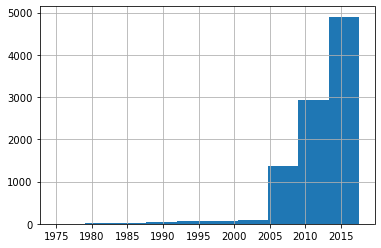

In [17]:
observations.date.hist()

From the above histogram it is clear that the majority of observations comes from recent years. This is in line with the fact that the raw data is also skewed towards more recent years. This could potentially impact the model since recent events (such as the 2008 crisis) could be over-weighted. For now we will leave this as is, but depending on how the model performs, a new cleaned dataset could be constructed where the dates are more balanced)

## Returns

In [18]:
observations[["1_month_return", "6_month_return", "12_month_return"]].describe()

,1_month_return,6_month_return,12_month_return
count,9500.000000,9500.000000,9500.000000
mean,0.006440,0.048104,0.089217
std,0.124710,0.407877,0.556537
min,-0.906412,-0.946269,-0.974157
25%,-0.040900,-0.101011,-0.144075
50%,0.004700,0.023505,0.038845
75%,0.047281,0.138902,0.216374
max,1.828125,14.736842,13.109024


From this overview, it appears that there are some extreme returns. For instance 921% returns in the 1 month returns, 515% returns in the 6 month returns, and 2071% returns in the 12 month returns. These outliers could make the trained model less generalizable. To prevent this, returns will be limited to 300% returns. This still corresponds to a 4X return over the period, which is highly unlikely but within reasonable bounds.

In [19]:
observations = observations[
    (observations["1_month_return"] <= 3) &
    (observations["6_month_return"] <= 3) &
    (observations["12_month_return"] <= 3)
].copy()

In [20]:
len(observations.index)

9444

From the original dataset of 9994 observations, 51 were removed leaving us with a dataset of 9943 observations.

## Volatility

In [21]:
# 1 month volatility
observations[["1_month_volatility", "6_month_volatility", "12_month_volatility"]].describe()

,1_month_volatility,6_month_volatility,12_month_volatility
count,9444.000000,9444.000000,9444.000000
mean,0.023440,0.024955,0.025811
std,0.028699,0.026651,0.029816
min,0.000000,0.000298,0.000318
25%,0.010355,0.011837,0.012269
50%,0.017378,0.019314,0.020085
75%,0.028794,0.031320,0.031969
max,1.324795,0.826326,1.151072


Similar to returns, there are some extremely high volatilities, expecially in the 6 and 12 month features. However, these are limited to very few observations and correspond to the remaining observations with very large returns. They are considered acceptable and will not be removed from the dataset.

# Set-up train/validation/test sets

Now the datasets will be split into 50% training, 25% validation, and 25% test sets

In [22]:
from sklearn.model_selection import train_test_split
import os

observations.drop(
    columns=["asset_file", "date"], # these features will not be taken into account during model training/testing
    inplace=True
)

train, temp = train_test_split(observations, test_size=0.5)
val, test = train_test_split(temp, test_size=0.5)

# Create directory
if not os.path.isdir("ModelData"):
    os.makedirs("ModelData")

train.to_csv("ModelData/obs_train.csv", index=False)
val.to_csv("ModelData/obs_val.csv", index=False)
test.to_csv("ModelData/obs_test.csv", index=False)